# <span style='color:#00dd00'>Train the EPG2S (EPG) Model</span>
## 1. Bulid EPG2S (EPG) model and training with EPG signal only.

Cache clean training data ...
../Dataset/elec/E173.csv not found.
Training set size: 222, Validation set size: 27
Training: E BiLSTM_512_512_L512 LSTM_384_L384 L257


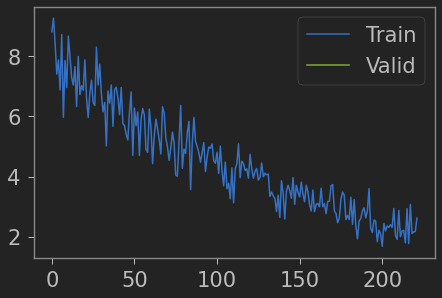

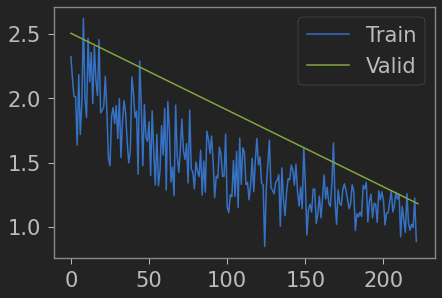

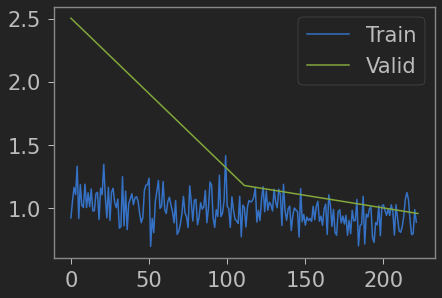

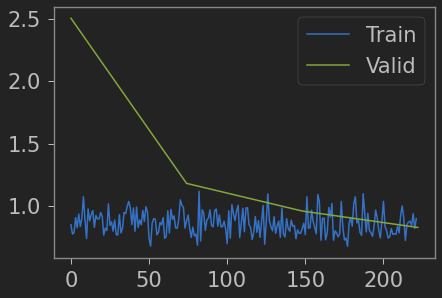

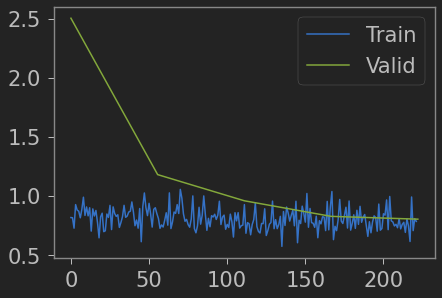

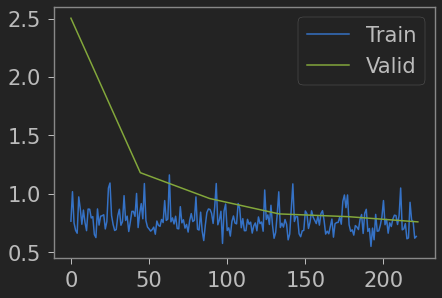

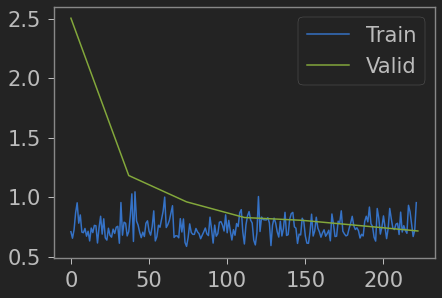

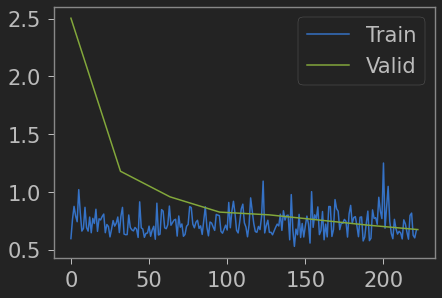

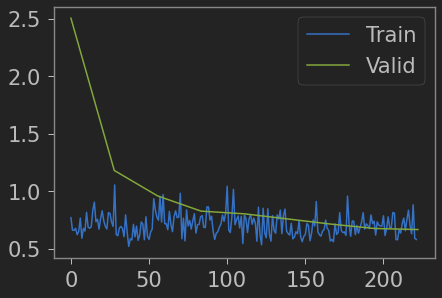

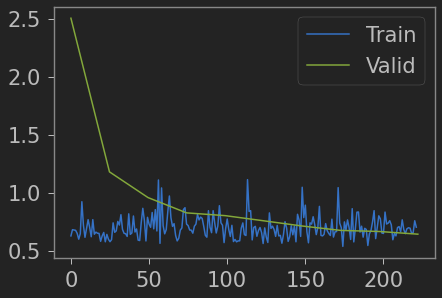

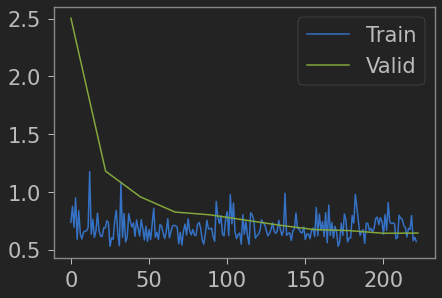

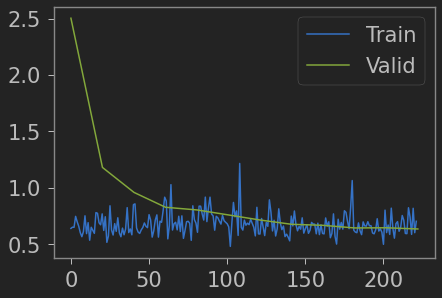

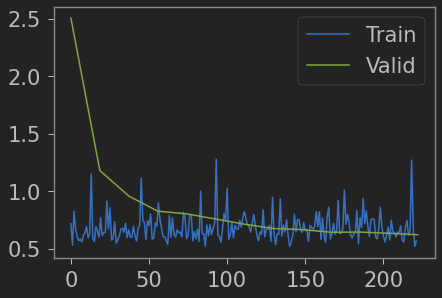

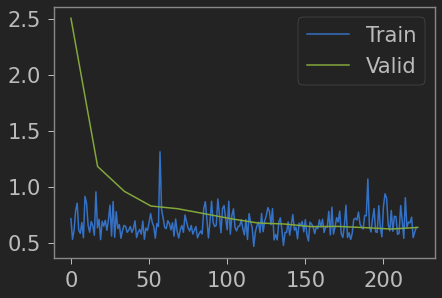

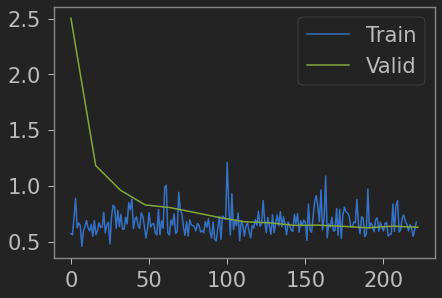

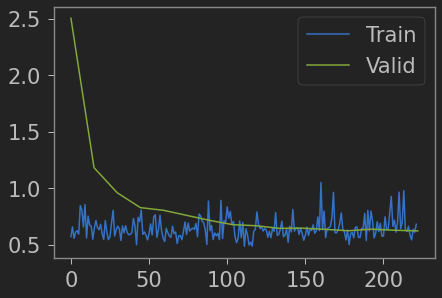

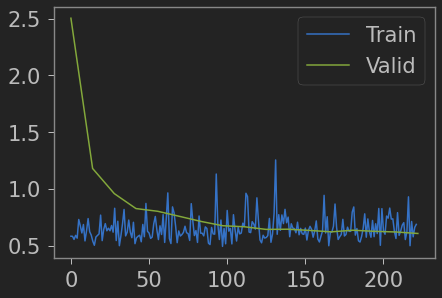

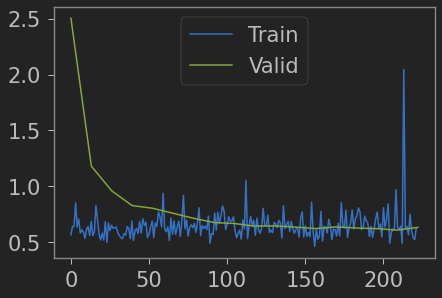

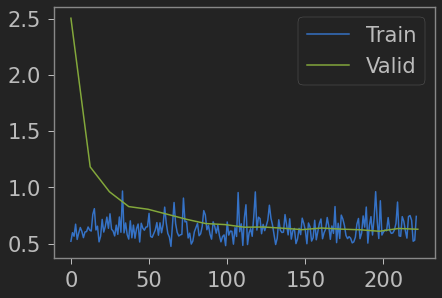

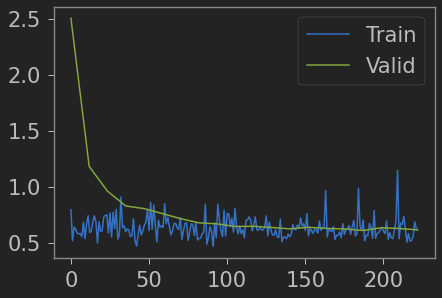

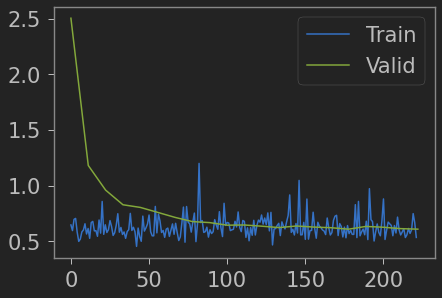

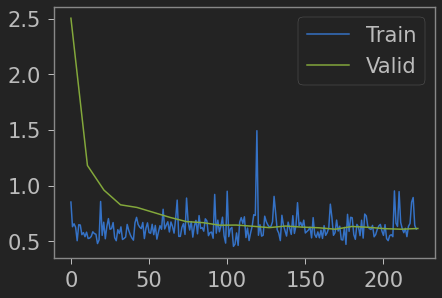

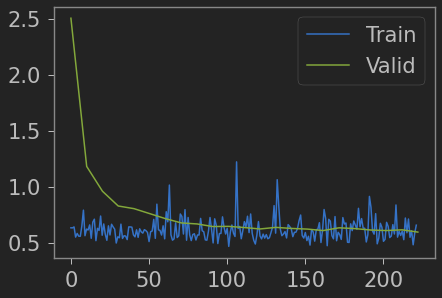

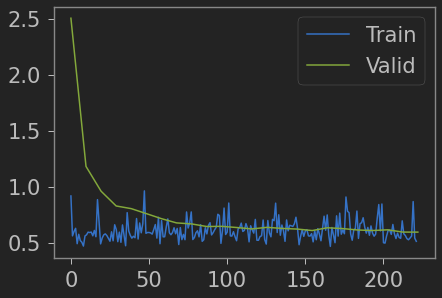

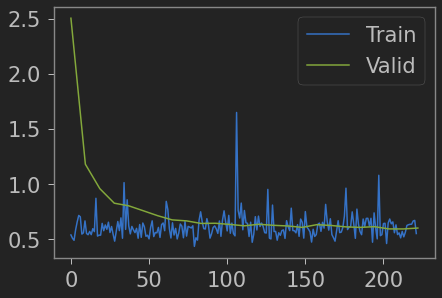

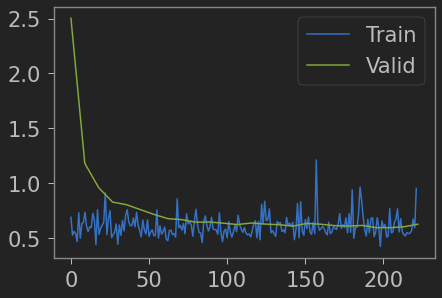

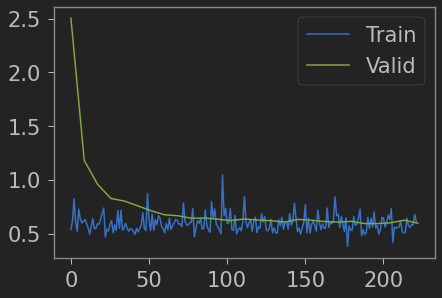

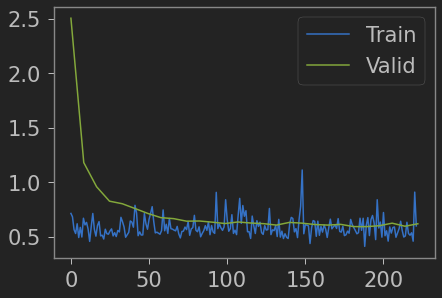

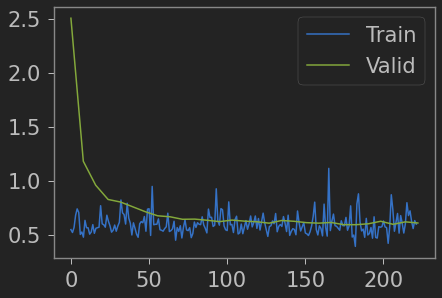

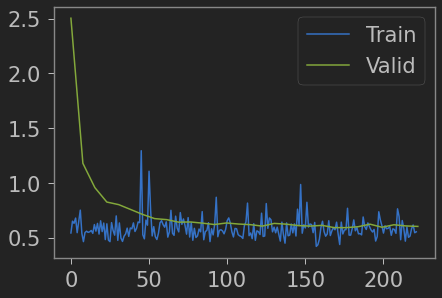

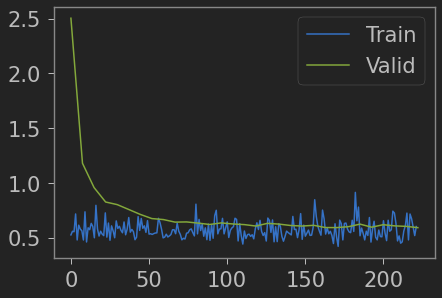

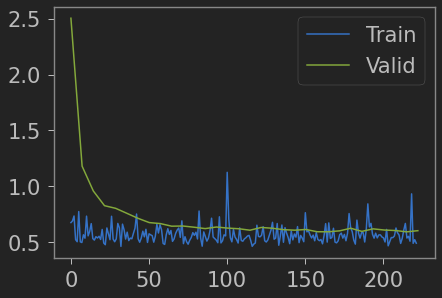

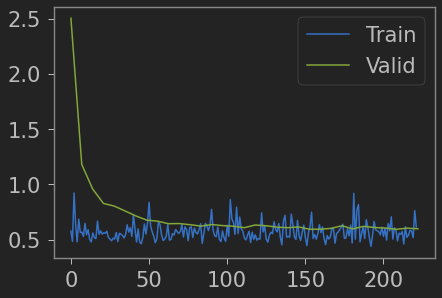

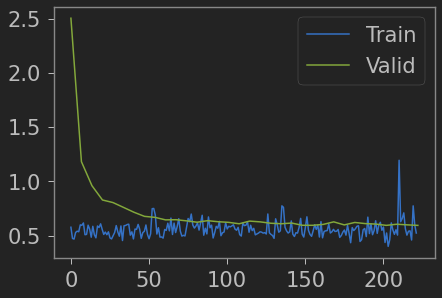

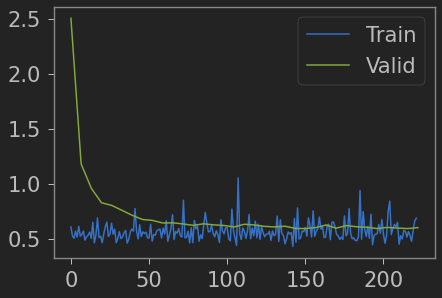

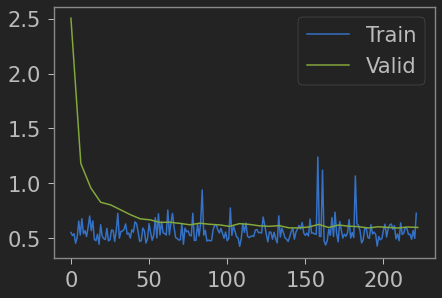

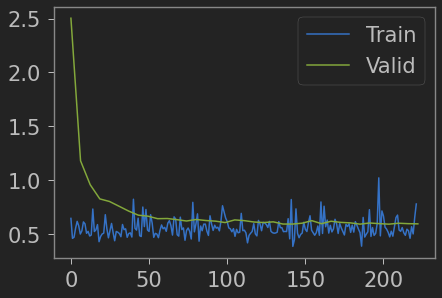

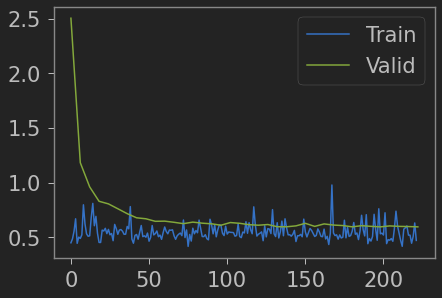

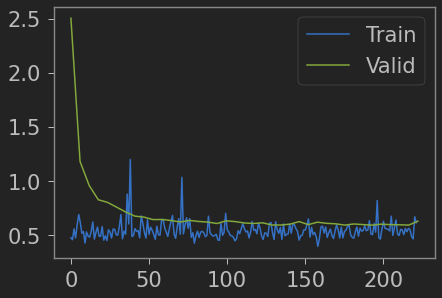

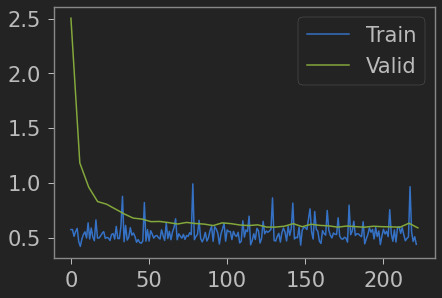

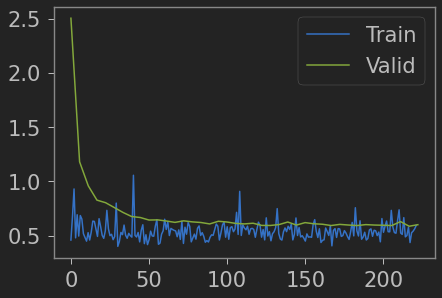

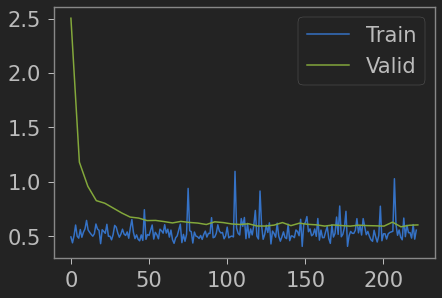

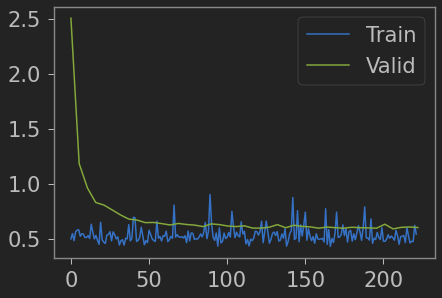

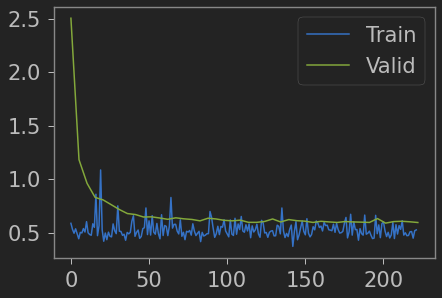

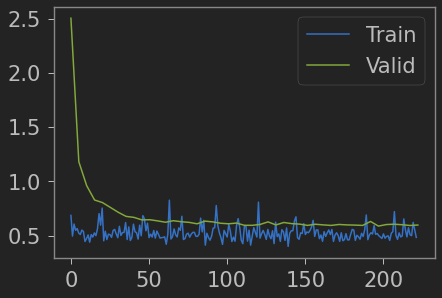

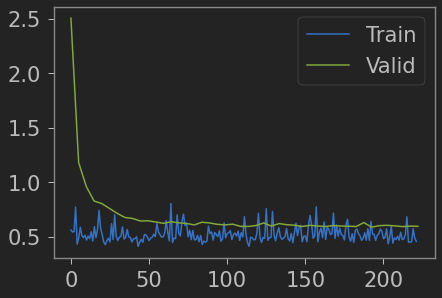

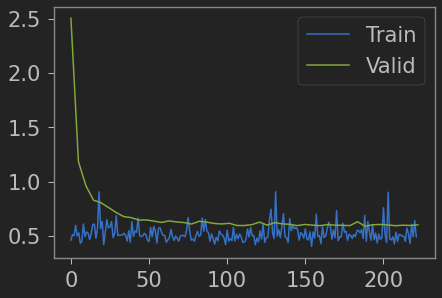

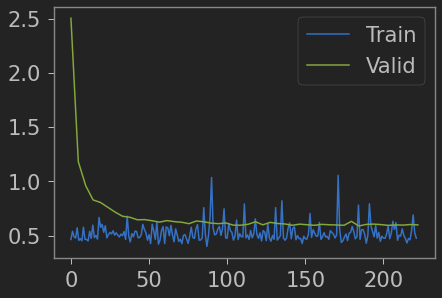

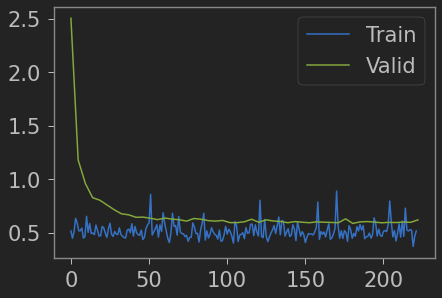

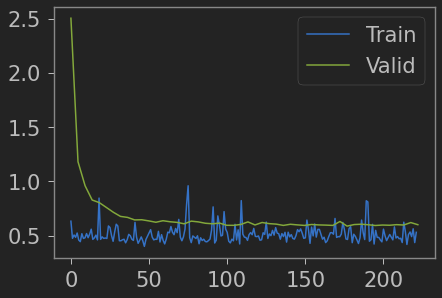

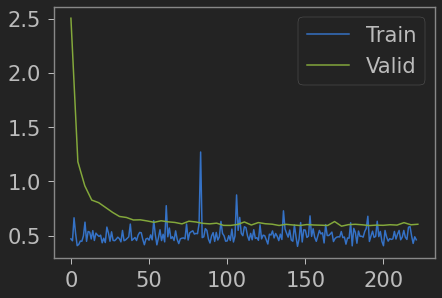

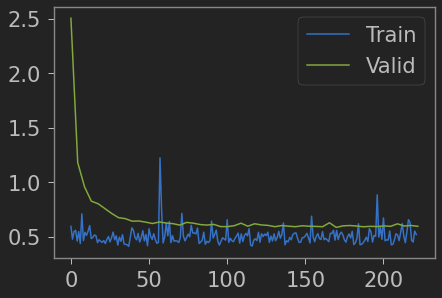

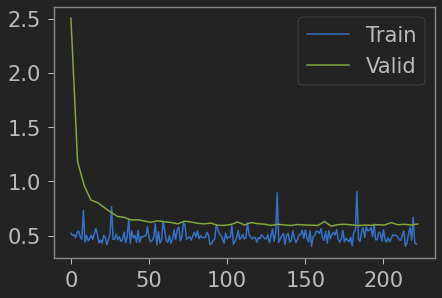

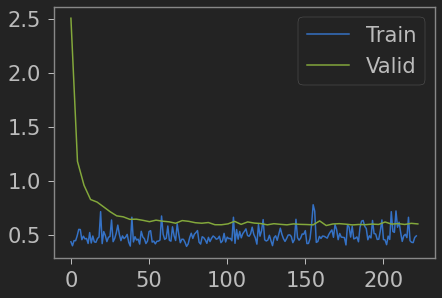

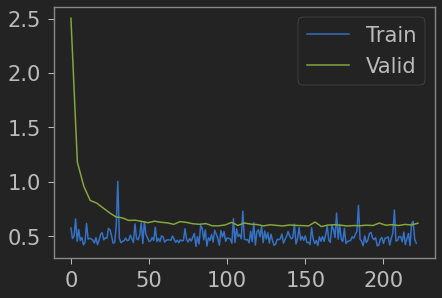

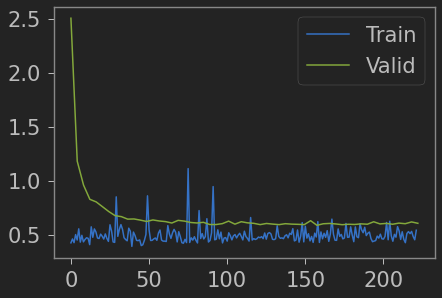

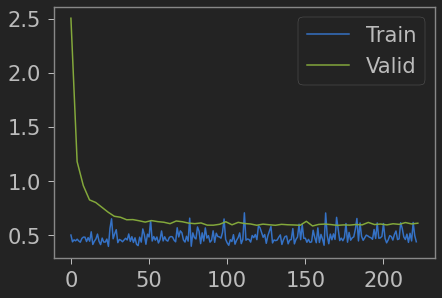

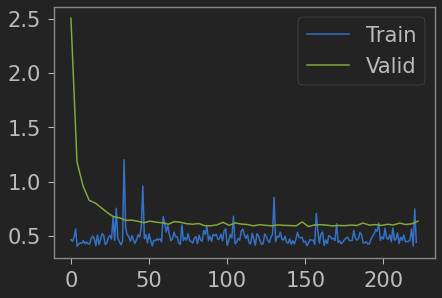

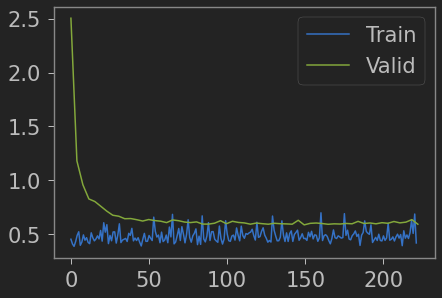

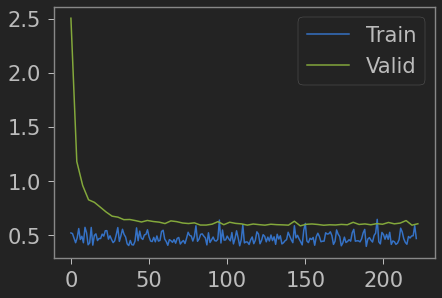

In [1]:
# Set the chart to dark mode
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False, fscale=2, figsize=(8, 6))

from main import *

if __name__ == '__main__':
    args.device = 'cuda:1'
    
    # ===== Build/Load MultiModal_SE =====
    model_name = 'E BiLSTM_512_512_L512 LSTM_384_L384 L257'
    
    model = MultiModal_SE()
#     model, from_epoch, valid_loss_threshold = model.load_model(
#         os.path.join(args.MM_checkpoint_path, f'{model_name}.pt'),
#         device=args.device
#     )
    from_epoch, valid_loss_threshold = 0, 1e9
    
    # (N, Seq, 257) -> (N, Seq, 4 * 128) or None
    model.S_Encoder = None
    
    # (N, Seq, 124) -> (N, Seq, 512) or None
    model.E_Encoder = nn.Sequential(OrderedDict([
        ('LSTM_0', nn.LSTM(input_size=124, hidden_size=256, bias=False, batch_first=True, dropout=0, bidirectional=True)),
        ('LSTM_1', nn.LSTM(input_size=512, hidden_size=256, bias=False, batch_first=True, dropout=0, bidirectional=True)),
        
        ('L_2', nn.Linear(512, 512, bias=False)),
        ('norm_2', nn.LayerNorm(512, elementwise_affine=True)),
        ('relu_2', nn.LeakyReLU(negative_slope=0.3)),
    ]))
    
    # (N, Seq, 2 Encoders input size) -> (N, Seq, fusion size) or None
    model.Fusion_layer = nn.Sequential(OrderedDict([
        ('lstm_4', nn.LSTM(input_size=512, hidden_size=384, bias=False, batch_first=True, dropout=0, bidirectional=False)),
        ('L_5', nn.Linear(384, 384, bias=False)),
        ('norm_5', nn.LayerNorm(384, elementwise_affine=True)),
        ('relu_5', nn.LeakyReLU(negative_slope=0.3)),
    ]))
    
    # (N, Seq, fusion size or S_Encoder latent size) -> (N, Seq, 257)
    model.S_Decoder = nn.Sequential(OrderedDict([
        ('L_6', nn.Linear(384, 257, bias=False)),
        ('relu_6', nn.LeakyReLU(negative_slope=0.3, inplace=True))
    ]))
    
    # (N, Seq, fusion size or S_Encoder latent size) -> (N, Seq, 124) or None
#     model.E_Decoder = nn.Sequential(OrderedDict([
#         ('L_6', nn.Linear(384, 124, bias=False)),
#         ('relu_6', nn.LeakyReLU(negative_slope=0.3, inplace=True)),
#     ]))

    model.is_late_fusion = True
    model.fusion_type = 'concat'
    model.fusion_channel = -1
    model.use_norm = True
    
    model.to(args.device)
#     print(model)
    
    # ===== Load Training clean data =====
    print('Cache clean training data ...')
    dataset = cache_clean_data(split_ratio=args.split_ratio, dataset_path=args.dataset_path, device=args.device)
    print(f"Training set size: {len(dataset['Train'])}, Validation set size: {len(dataset['Valid'])}")
    
    loss_fn = nn.MSELoss()
    feat_loss_fn = nn.SmoothL1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
#     scheduler = torch.optim.lr_scheduler.LambdaLR(
#         optimizer,
# #         lr_lambda=lambda epoch: epoch / 10.0 if epoch < 10 else 0.9 ** epoch
#         lr_lambda=lambda epoch: 1
#     )
    
    # ===== Training =====
    print(f'Training: {model_name}')
    train(model, dataset,
          from_epoch, args.batch_size,
          valid_loss_threshold, args.loss_coef,
          loss_fn, feat_loss_fn, optimizer,
          save_filename=os.path.join(args.MM_checkpoint_path, model_name),
          dataset_path=args.dataset_path,
          use_elec = True, elec_only = True, use_zero_pad=False,
          early_stop_step=20,
    )

## 2. Evaluate the EPG2S (EPG) model in the test set and save the results.

In [2]:
import os
import pickle

from model import MultiModal_SE
from preprocess import cache_clean_data
from utils import analyze
from main import args

if __name__ == '__main__':
#     args.device = 'cuda:0'
    
    # ===== Load Test clean data =====
    print('Cache clean testing data ...')
    dataset = cache_clean_data(is_training=False, dataset_path=args.dataset_path, device=args.device)
    print(f"Test set size: {len(dataset['Test'])}")
    
    # ===== Test set performance =====
    model_name = 'E BiLSTM_512_512_L512 LSTM_384_L384 L257'
    model, e, v = MultiModal_SE().load_model(
        os.path.join(args.MM_checkpoint_path, f'{model_name}.pt'),
        device=args.device
    )
    print(f'Epoch: {e}, valid loss: {v}')
    
    analyze(
        model, dataset, model_name,
        processes=8,
        use_S=False,
        elec_only=True,
        use_griffin=True,
        evaluation_path=args.evaluation_path,
        dataset_path=args.dataset_path
    )

Cache clean testing data ...
Test set size: 70
Model './checkpoint/MultiModal/E BiLSTM_512_512_L512 LSTM_384_L384 L257.pt' loaded.
Epoch: 40, valid loss: 0.5878881801057745


## 3. Show the average results of EPG2S (EPG)

['n10dB', 'n5dB', '0dB', '5dB']
====
PESQ:
	EPG2S$_{baseline}$ V2 :	[2.03398979 2.02744417 2.03102809 2.04358412]	2.034011544925826
====
STOI:
	EPG2S$_{baseline}$ V2 :	[0.59086984 0.5897207  0.58923106 0.59056844]	0.590097510065236
====
ESTOI:
	EPG2S$_{baseline}$ V2 :	[0.31854661 0.31761261 0.31767039 0.31853874]	0.31809208726521854


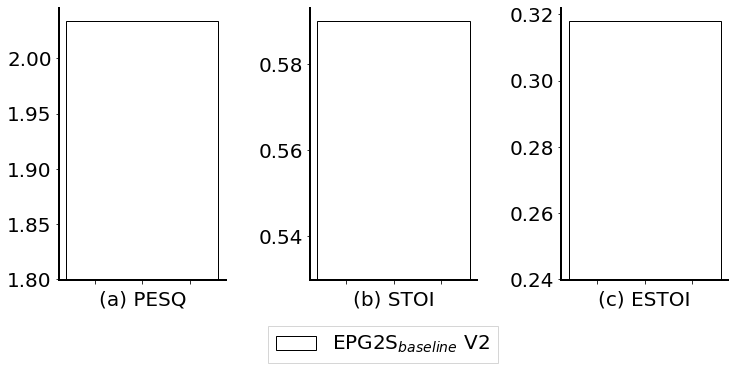

In [3]:
from main import *
import matplotlib.pyplot as plt

if __name__ == '__main__':
    plt.rcParams.update({
        'font.size': 20,
        'axes.linewidth': 2,
        'legend.shadow':False,
        'legend.fancybox':False,
    })
    
    compare_dict = {
        'EPG2S$_{baseline}$ V2': 'E BiLSTM_512_512_L512 LSTM_384_L384 L257',
    }
    
    avg_analyze(
        compare_dict=compare_dict,
        evaluation_path=args.evaluation_path,
        metrics=['PESQ', 'STOI', 'ESTOI'],
        bottom={ 'PESQ': 1.8, 'STOI': 0.53, 'ESTOI': 0.24 },
        test_noise_type=['none'],
        test_SNR_type=['n10dB', 'n5dB', '0dB', '5dB'], #'10dB'],
        patterns=' .-*o\\O/+ .-*o\\O/+',
        figsize=(12, 5),
        show='text/graph',
#         use_label=True,
#         save_dir='Test'
    )
    